In [1]:
# Import TF 2.x
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.13.0

Hub version: 0.15.0

GPU available (YESS!!!!)


In [5]:
import numpy as np

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-10-20 09:48:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-20 09:48:02 (70.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("/kaggle/input/agricultural-pests-dataset/train")

There are 12 directories and 0 images in '/kaggle/input/agricultural-pests-dataset/train'.
There are 0 directories and 331 images in '/kaggle/input/agricultural-pests-dataset/train/beetle'.
There are 0 directories and 390 images in '/kaggle/input/agricultural-pests-dataset/train/grasshopper'.
There are 0 directories and 246 images in '/kaggle/input/agricultural-pests-dataset/train/earthworms'.
There are 0 directories and 400 images in '/kaggle/input/agricultural-pests-dataset/train/ants'.
There are 0 directories and 390 images in '/kaggle/input/agricultural-pests-dataset/train/earwig'.
There are 0 directories and 405 images in '/kaggle/input/agricultural-pests-dataset/train/snail'.
There are 0 directories and 329 images in '/kaggle/input/agricultural-pests-dataset/train/catterpillar'.
There are 0 directories and 394 images in '/kaggle/input/agricultural-pests-dataset/train/weevil'.
There are 0 directories and 405 images in '/kaggle/input/agricultural-pests-dataset/train/bees'.
There ar

In [95]:

# Create training and test directories
train_dir = "/kaggle/input/agricultural-pests-dataset/train/"
test_dir = "/kaggle/input/agricultural-pests-dataset/test/"

In [98]:
test_dir

'/kaggle/input/agricultural-pests-dataset/test/'

In [96]:
train_dir

'/kaggle/input/agricultural-pests-dataset/train/'

In [109]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 4395 files belonging to 12 classes.
Found 1099 files belonging to 12 classes.


In [110]:
# How many images are there of each breed?
outputs=len(train_data.class_names)

In [111]:
classes=train_data.class_names

In [112]:
classes

['ants',
 'bees',
 'beetle',
 'catterpillar',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'slug',
 'snail',
 'wasp',
 'weevil']

In [113]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2) # stops after 3 rounds of no improvements

In [114]:
# How many rounds should we get the model to look through the data?
NUM_EPOCHS = 50 #@param {type:"slider", min:10, max:100, step:10}

In [115]:
# model = create_model()


# history=model.fit(x=train_data,
#             epochs=NUM_EPOCHS,
#             validation_data=val_data,
#             validation_freq=1, # check validation metrics every epoch
#             callbacks=[ early_stopping])

In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

In [144]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False  # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# Add L2 regularization to the Dense layer
x = layers.Dense(12, kernel_regularizer=regularizers.l2(0.001))(x)

# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)


In [134]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [118]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # Load EfficientNetB0 from TensorFlow Hub
# efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# # https://tfhub.dev/tensorflow/efficientnet/b7/classification/1
# feature_extractor = hub.KerasLayer(efficientnet_url, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# # Create a model using EfficientNetB0 as the feature extractor
# model = tf.keras.Sequential([
#     feature_extractor,
#     tf.keras.layers.Dense(OUTPUT_SHAPE, activation='softmax')  # Output layer with softmax activation
# ])

# # Compile the model
# model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     optimizer=tf.keras.optimizers.Adam(),
#     metrics=['accuracy']
# )

# # Display the model summary
# model.summary()


In [145]:
# Train the model
model.fit(train_data, epochs=5
          , validation_data=test_data,callbacks=[ early_stopping])


Epoch 1/5
138/138 [==============================] - 16s 71ms/step - loss: 0.7924 - accuracy: 0.8193 - val_loss: 0.4262 - val_accuracy: 0.8908
Epoch 2/5
138/138 [==============================] - 8s 59ms/step - loss: 0.3424 - accuracy: 0.9188 - val_loss: 0.3682 - val_accuracy: 0.8990
Epoch 3/5
138/138 [==============================] - 8s 60ms/step - loss: 0.2850 - accuracy: 0.9370 - val_loss: 0.3469 - val_accuracy: 0.9063
Epoch 4/5
138/138 [==============================] - 8s 60ms/step - loss: 0.2543 - accuracy: 0.9454 - val_loss: 0.3367 - val_accuracy: 0.9045
Epoch 5/5
138/138 [==============================] - 8s 60ms/step - loss: 0.2335 - accuracy: 0.9531 - val_loss: 0.3353 - val_accuracy: 0.9081


In [121]:
# Classes we're working with
classes = list(classes)

In [122]:
classes

['ants',
 'bees',
 'beetle',
 'catterpillar',
 'earthworms',
 'earwig',
 'grasshopper',
 'moth',
 'slug',
 'snail',
 'wasp',
 'weevil']

In [146]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [161]:
import matplotlib.pyplot as plt

In [157]:
class_names = classes

In [166]:
load  = tf.keras.models.load_model("/kaggle/working/pest_classication.h5")

1/1 [==============================] - 1s 1s/step


(-0.5, 223.5, 223.5, -0.5)

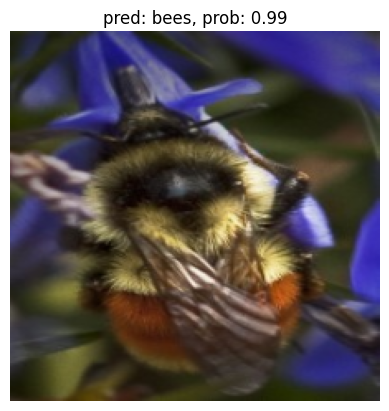

In [167]:
img = "/kaggle/input/agricultural-pests-dataset/test/bees/bees (102).jpg"
img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
pred_prob = load.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
plt.figure()
plt.imshow(img/255.) # imshow() requires float inputs to be normalized
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)